In [8]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Quora_Duplicate_Questions.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
set_seed(69)

PATH = 'drive/MyDrive/Quora_Duplicate_Questions/'
data = pd.read_csv(PATH+'src/data_engineered.csv', index_col='id')

fs1 = ['q1_len', 'q2_len', 'len_difference', 'len_abs_difference',
       'q1_char_len', 'q2_char_len', 'q1_num_words', 'q2_num_words',
       'q1_freq', 'q2_freq', 'total_freq', 'abs_diff_freq', 
        'num_common_words', 'ratio_common_words']

fs2 = ['fuzz_qratio', 'fuzz_Wratio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

fs3_1 = get_pickle('fs3_1')
fs3_2 = get_pickle('fs3_2')
fs3_3 = get_pickle('fs3_3')
fs3_4 = get_pickle('fs3_4')
fs3_5 = get_pickle('fs3_5')

fs4_1 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

fs4_2 = ['wmd', 'norm_wmd']

w2v = get_pickle('w2v')

In [3]:
scaler = StandardScaler()
y = data.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)
X = data[fs1+fs2+fs4_1+fs4_2]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
X = np.hstack((X, fs3_3, fs3_4, w2v))

n_all = y.shape[0]
idx = np.arange(n_all)
np.random.shuffle(idx)
n_split = n_all // 10
idx_val = idx[:n_split]
idx_train = idx[n_split:]
x_train = X[idx_train]
y_train = np.ravel(y[idx_train])
x_val = X[idx_val]
y_val = np.ravel(y[idx_val])

In [ ]:
xgb_params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}
boost = xgb.XGBClassifier(
    objective= 'binary:logistic',
    eval_metric= ['logloss', 'error'],
    tree_method= "gpu_hist",
    gpu_id= 0,
    eta= 0.02,
    early_stopping_rounds=50,
    verbose_eval=100,
)
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_val, label=y_val)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = GridSearchCV(boost, xgb_params).fit(x_train, y_train)

xgb_preds = (bst.predict(d_valid) >= 0.5).astype(int)
xgb_accuracy = np.sum(xgb_preds == y_val) / len(y_val)
print("Xgb accuracy: %0.3f" % xgb_accuracy)

TypeError: ignored

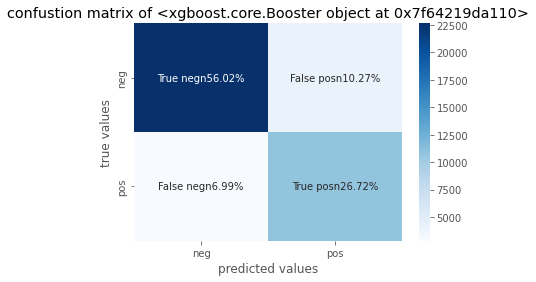

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
def scr(clf, y_val, ytrue):
        y_pred = (clf.predict(y_val) >= 0.5).astype(int)
        cm = confusion_matrix(y_pred, ytrue)
        cats = ['neg', 'pos']
        groups = ['True neg', 'False pos', 'False neg', 'True pos']
        group_percents = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1}n{v2}' for v1, v2 in zip(groups, group_percents)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cm, annot=labels, cmap='Blues', xticklabels=cats, yticklabels=cats, fmt='')
        plt.xlabel('predicted values')
        plt.ylabel('true values')
        plt.title(f'confustion matrix of {clf}')
        print(f'{clf}\n', classification_report(y_val, y_pred))
        print(f'best params: {clf.best_params_}, score: {clf.score(d_valid)}')
scr(bst, x_val, y_val)

In [7]:
print(classification_report(xgb_preds, y_val))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     26798
           1       0.72      0.79      0.76     13631

    accuracy                           0.83     40429
   macro avg       0.81      0.82      0.81     40429
weighted avg       0.83      0.83      0.83     40429



In [ ]:
bst.get_score()